# 1. Introduction and Objective

**Research Question:**  
Is there a relationship between fuel prices and congestion?

**Task Description:**  
Prove or disprove the relationship using data science methods,  
with the city of **Düsseldorf** as a case study.

**Objective:**  
To investigate how fluctuations in fuel prices may influence traffic congestion levels, using historical fuel price and traffic data. The analysis will involve data collection, preprocessing, visualization, and statistical modeling.


# 2. Data Acquisition

To explore the relationship between fuel prices and congestion in Düsseldorf, i will collect the following datasets:

### Traffic Congestion Data

- **Description**: Hourly vehicle counts from selected automatic traffic counting stations (Automatische Dauerzählstellen) provided by BASt.
- **Data Source**: Bundesanstalt für Straßenwesen (BASt) – [www.bast.de](https://www.bast.de)
- **Note**: Only stations with reliable and continuous data ("belastbare Zähldaten") will be included in the final analysis.

**List of Candidate Zählstellen near Düsseldorf:**

| Road | Station Name             | Station ID | Remark                          |
|------|---------------------------|------------|---------------------------------|
| A3   | AK Breitscheid (S)        | 5065       | Available                       |
| A52  | AK Breitscheid (O)        | 5639       | Keine belastbaren Zähldaten     |
| A52  | AK Breitscheid (W)        | 5637       | Available                       |
| A3   | AK Hilden (N)             | 5655       | Keine belastbaren Zähldaten     |
| A3   | AK Hilden (S)             | 5657       | Keine belastbaren Zähldaten     |
| A46  | AK Hilden (O)             | 5023       | Keine belastbaren Zähldaten     |
| A46  | AK Hilden (W)             | 5658       | Available                       |
| A46  | Düsseldorf-Flehe          | 5040       | Keine belastbaren Zähldaten      |
| A46  | Neuss-Holzheim            | 5016       | Available                       |
| A52  | Lintorf                   | 5027       | Available                       |
| B7   | Düsseldorf-Heerdt         | 5031       | Keine belastbaren Zähldaten     |
| A59  | Düsseldorf-Urdenbach      | 5090       | Available                       |
| A59  | Langenfeld                | 5007       | Available                       |



In [ ]:
# Available Station IDs
station_ids = [
    5065,  # A3 AK Breitscheid (S)
    5637,  # A52 AK Breitscheid (W)
    5658,  # A46 AK Hilden (W)
    5016,  # A46 Neuss-Holzheim
    5027,  # A52 Lintorf
    5090,  # A59 Düsseldorf-Urdenbach
    5007   # A59 Langenfeld
]


In [5]:
import os
import requests
import zipfile
import pandas as pd


/Users/lazyallen/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Data Coverage

This project uses traffic data collected by automatic counting stations, covering the years 2003 to 2023.
To keep the analysis consistent and meaningful, data from January 2020 to December 2021 was left out. That’s when COVID-19 caused major disruptions—lockdowns, remote work, and travel restrictions completely changed how people moved around, so traffic during that time wouldn’t reflect normal fuel price and congestion patterns.


In [8]:

base_dir = "vehicle_counts"
os.makedirs(base_dir, exist_ok=True)

# To ensure consistency and avoid structural distortions caused by COVID-19, data from the period **January 2020 to December 2021** has been excluded from the analysis.  

years = [y for y in range(2003, 2024) if y not in [2020, 2021]]

station_ids = [
    5065,
    5637,
    5658,
    5016,
    5027,
    5090,
    5007
]

def parse_datum(val):
    val = str(val).zfill(6)
    year = int(val[:2]) + 2000
    month = int(val[2:4])
    day = int(val[4:6])
    return f"{year:04d}-{month:02d}-{day:02d}"


for year in years:
    year_dir = os.path.join(base_dir, str(year))
    os.makedirs(year_dir, exist_ok=True)
    all_year_data = []

    for station_id in station_ids:
        zip_filename = f"zst{station_id}.zip"
        zip_path = os.path.join(year_dir, zip_filename)
        extract_path = os.path.join(year_dir, f"zst{station_id}")

        url = f"https://www.bast.de/videos/{year}/zst{station_id}.zip"
        try:
            print(f"Downloading {url} ...")
            response = requests.get(url, timeout=30)

            if response.status_code == 200:
                with open(zip_path, 'wb') as f:
                    f.write(response.content)
                print(f"Saved to {zip_path}")

                os.makedirs(extract_path, exist_ok=True)
                with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                    zip_ref.extractall(extract_path)
                print(f"Extracted to {extract_path}")
            else:
                print(f"Failed to download {url} (Status code: {response.status_code})")
        except Exception as e:
            print(f"Error downloading {url}: {e}")
            continue

        for root, dirs, files in os.walk(extract_path):
            for file in files:
                if file.endswith(".csv"):
                    file_path = os.path.join(root, file)
                    try:
                        df = pd.read_csv(file_path, sep=';', encoding='latin1')
                        df["station_id"] = station_id
                        df["date"] = df["Datum"].apply(parse_datum)

                        df["KFZ_R1"] = pd.to_numeric(df["KFZ_R1"], errors="coerce")
                        df["KFZ_R2"] = pd.to_numeric(df["KFZ_R2"], errors="coerce")
                        df["vehicle_total"] = df["KFZ_R1"] + df["KFZ_R2"]

                        daily = df.groupby(["date","station_id"], as_index=False)["vehicle_total"].sum()
                        all_year_data.append(daily)
                    except Exception as e:
                        print(f"Failed to process {file_path}: {e}")
    if all_year_data:
        combined = pd.concat(all_year_data, ignore_index=True)
        daily_total = combined.groupby("date", as_index=False)["vehicle_total"].sum()
        output_csv = os.path.join(year_dir, f"daily_{year}.csv")
        daily_total.to_csv(output_csv, index=False)
        print(f"Saved daily data to {output_csv}")
    else:
        print(f"No data for year {year}")


Saved to vehicle_counts/2003/zst5065.zip
Extracted to vehicle_counts/2003/zst5065
Saved to vehicle_counts/2003/zst5637.zip
Extracted to vehicle_counts/2003/zst5637
Saved to vehicle_counts/2003/zst5658.zip
Extracted to vehicle_counts/2003/zst5658
Saved to vehicle_counts/2003/zst5016.zip
Extracted to vehicle_counts/2003/zst5016
Saved to vehicle_counts/2003/zst5027.zip
Extracted to vehicle_counts/2003/zst5027
Saved to vehicle_counts/2003/zst5090.zip
Error downloading https://www.bast.de/videos/2003/zst5090.zip: File is not a zip file
Saved to vehicle_counts/2003/zst5007.zip
Extracted to vehicle_counts/2003/zst5007
Saved daily data to vehicle_counts/2003/daily_2003.csv
Saved to vehicle_counts/2004/zst5065.zip
Extracted to vehicle_counts/2004/zst5065
Saved to vehicle_counts/2004/zst5637.zip
Extracted to vehicle_counts/2004/zst5637
Saved to vehicle_counts/2004/zst5658.zip
Extracted to vehicle_counts/2004/zst5658
Saved to vehicle_counts/2004/zst5016.zip
Extracted to vehicle_counts/2004/zst501

In [11]:
from datetime import date

for year in years:
    file_path = os.path.join(base_dir, str(year), f"daily_{year}.csv")
    
    if not os.path.exists(file_path):
        print(f"{year}: File not found.")
        continue

    print(f"\n=== Year {year} ===")
    try:
        df = pd.read_csv(file_path, parse_dates=["date"])
    except Exception as e:
        print(f"Failed to read {file_path}: {e}")
        continue

    missing = df.isnull().sum()
    if missing.any():
        print("Missing values found:")
        print(missing[missing > 0])
    else:
        print("No missing values.")

    df_sorted = df.sort_values("date")
    start_date = date(year, 1, 1)
    end_date = date(year, 12, 31)
    expected_dates = pd.date_range(start=start_date, end=end_date)
    actual_dates = pd.to_datetime(df_sorted["date"])
    missing_dates = expected_dates.difference(actual_dates)

    if missing_dates.empty:
        print("Date is continuous.")
    else:
        print(f"Missing {len(missing_dates)} date(s):")
        print(missing_dates.strftime("%Y-%m-%d").to_list())

    zero_traffic = df[df["vehicle_total"] == 0]
    if zero_traffic.empty:
        print("No zero-traffic days.")
    else:
        print(f"{len(zero_traffic)} day(s) with zero vehicle count:")
        print(zero_traffic[["date", "vehicle_total"]])


=== Year 2003 ===
No missing values.
Date is continuous.
No zero-traffic days.

=== Year 2004 ===
No missing values.
Date is continuous.
No zero-traffic days.

=== Year 2005 ===
No missing values.
Date is continuous.
No zero-traffic days.

=== Year 2006 ===
No missing values.
Date is continuous.
No zero-traffic days.

=== Year 2007 ===
No missing values.
Date is continuous.
No zero-traffic days.

=== Year 2008 ===
No missing values.
Date is continuous.
No zero-traffic days.

=== Year 2009 ===
No missing values.
Date is continuous.
No zero-traffic days.

=== Year 2010 ===
No missing values.
Date is continuous.
No zero-traffic days.

=== Year 2011 ===
No missing values.
Date is continuous.
No zero-traffic days.

=== Year 2012 ===
No missing values.
Date is continuous.
No zero-traffic days.

=== Year 2013 ===
No missing values.
Date is continuous.
No zero-traffic days.

=== Year 2014 ===
No missing values.
Date is continuous.
No zero-traffic days.

=== Year 2015 ===
No missing values.
Da

In [13]:
all_data = []

for year in years:
    file_path = os.path.join(base_dir, str(year), f"daily_{year}.csv")
    
    if not os.path.exists(file_path):
        print(f"{year}: File not found.")
        continue

    try:
        df = pd.read_csv(file_path, parse_dates=["date"])
        all_data.append(df)
        print(f"{year}: Loaded {len(df)} rows.")
    except Exception as e:
        print(f"{year}: Failed to load - {e}")

if all_data:
    combined_df = pd.concat(all_data, ignore_index=True)
    combined_df.to_csv("vehicle_counts_daily.csv", index=False)
    print("Saved combined file: vehicle_counts_daily.csv")

2003: Loaded 365 rows.
2004: Loaded 366 rows.
2005: Loaded 365 rows.
2006: Loaded 365 rows.
2007: Loaded 365 rows.
2008: Loaded 366 rows.
2009: Loaded 365 rows.
2010: Loaded 365 rows.
2011: Loaded 365 rows.
2012: Loaded 366 rows.
2013: Loaded 365 rows.
2014: Loaded 365 rows.
2015: Loaded 365 rows.
2016: Loaded 366 rows.
2017: Loaded 365 rows.
2018: Loaded 365 rows.
2019: Loaded 365 rows.
2022: Loaded 365 rows.
2023: Loaded 365 rows.
Saved combined file: vehicle_counts_daily.csv


### Fuel Price Data

I use fuel price data from [Tankerkoenig](https://tankerkoenig.de/) covering the period from **2014-06-08** to **2023-12-31**.

Due to the large size of the Tankerkoenig dataset, I restrict the analysis period to the range from **2014-07-01 to 2019-12-31.**

To focus on the Düsseldorf area, I first extract the UUIDs of all fuel stations located in Düsseldorf using the station metadata files. These UUIDs are then used to filter the price data from the /prices/ directory.

Daily fuel prices for E5, E10, and Diesel are aggregated across all Düsseldorf stations to construct time series of average daily fuel prices. These serve as key explanatory variables in the analysis of traffic congestion.

In [16]:
df = pd.read_csv('/Users/monica/tmp1/tankerkoenig-data/stations.csv')
duesseldorf_stations = df[df['city'].str.lower().str.contains('düsseldorf', na=False)]
duesseldorf_stations.to_csv('duesseldorf_stations.csv', index=False)
uuid_list = duesseldorf_stations['uuid'].tolist()


In [24]:
base_path = '/Users/monica/tmp1/tankerkoenig-data/prices'
fuel_prices_dir = 'fuel_prices'
os.makedirs(output_dir, exist_ok=True)
date_range = pd.date_range('2014-07-01', '2019-12-31', freq='D')
# date_range = pd.date_range('2014-07-01', '2014-12-31', freq='D')
date_range = date_range[::-1]
yearly_data = {}

for date in date_range:
    y, m, d = date.year, f"{date.month:02d}", f"{date.day:02d}"
    file_path = f"{base_path}/{y}/{m}/{y}-{m}-{d}-prices.csv"
    if not os.path.exists(file_path):
        continue
    df = pd.read_csv(file_path, sep='\t')
    df = df[df['station_uuid'].isin(uuid_list)]
    df = df[(df['dieselchange'] == 1) & (df['e5change'] == 1) & (df['e10change'] == 1)]
    if df.empty:
        continue
    row = {
        'date': date.strftime('%Y-%m-%d'),
        'diesel': round(df['diesel'].mean(),3),
        'e5': round(df['e5'].mean(),3),
        'e10': round(df['e10'].mean(),3)
    }
    if y not in yearly_data:
        yearly_data[y] = []
    yearly_data[y].append(row)

for y, rows in yearly_data.items():
    out_df = pd.DataFrame(rows)
    out_df.to_csv(f'{fuel_prices_dir}/prices_{y}.csv', index=False)

In [27]:
fuel_prices_dir = 'fuel_prices'

all_files = [os.path.join(fuel_prices_dir, f) for f in os.listdir(fuel_prices_dir) if f.endswith('.csv')]

df_list = [pd.read_csv(f) for f in all_files]
merged_df = pd.concat(df_list, ignore_index=True)
merged_df = merged_df.sort_values('date')

merged_df.to_csv('duesseldorf_fuel_prices.csv', index=False)

In [32]:
from datetime import date

df = pd.read_csv('duesseldorf_fuel_prices.csv', parse_dates=["date"])
print("=== Checking duesseldorf_fuel_prices ===")
missing = df.isnull().sum()
if missing.any():
    print("Missing values found:")
    print(missing[missing > 0])
else:
    print("No missing values.")

df_sorted = df.sort_values("date")
start_date = date(2014, 7, 1)
end_date = date(2019, 12, 31)
expected_dates = pd.date_range(start=start_date, end=end_date)
actual_dates = pd.to_datetime(df_sorted["date"])
missing_dates = expected_dates.difference(actual_dates)

if missing_dates.empty:
    print("Date is continuous.")
else:
    print(f"Missing {len(missing_dates)} date(s):")
    print(missing_dates.strftime("%Y-%m-%d").to_list())

zero_price = df[(df["diesel"] == 0) | (df["e5"] == 0) | (df["e10"] == 0)]
if zero_price.empty:
    print("No zero-price days.")
else:
    print(f"{len(zero_price)} day(s) with zero price:")
    print(zero_price[["date", "diesel", "e5", "e10"]])

=== Checking duesseldorf_fuel_prices ===
No missing values.
Date is continuous.
No zero-price days.


### Inflation Adjustment

To account for inflation, I adjust nominal fuel prices using the German Consumer Price Index (CPI), sourced from:
[Destatis Table 61111-0002](https://www-genesis.destatis.de/datenbank/online/statistic/61111/table/61111-0002)



In [37]:
df = pd.read_csv('cpi_germany_months/61111-0002_en_flat.csv',sep=';')
df = df[df['value_variable_label'] == 'Consumer price index']

month_map = {
    'MONAT01': '01', 'MONAT02': '02', 'MONAT03': '03', 'MONAT04': '04',
    'MONAT05': '05', 'MONAT06': '06', 'MONAT07': '07', 'MONAT08': '08',
    'MONAT09': '09', 'MONAT10': '10', 'MONAT11': '11', 'MONAT12': '12'
}

df['month'] = df['1_variable_attribute_code'].map(month_map)
df['date'] = pd.to_datetime(df['time'].astype(str) + '-' + df['month'] + '-01')
df = df[['date', 'value']].rename(columns={'value': 'cpi'})
df = df.sort_values('date')

df.to_csv('germany_cpi_monthly.csv', index=False)

In [39]:
fuel = pd.read_csv('duesseldorf_fuel_prices.csv', parse_dates=['date'])
cpi = pd.read_csv('germany_cpi_monthly.csv', parse_dates=['date'])

cpi['month'] = cpi['date'].dt.to_period('M')
fuel['month'] = fuel['date'].dt.to_period('M')

merged = pd.merge(fuel, cpi[['month', 'cpi']], on='month', how='left')

base_cpi = cpi[cpi['date'] == '2019-12-01']['cpi'].iloc[0]

for col in ['diesel', 'e5', 'e10']:
        merged[f'{col}_real'] = (merged[col] * base_cpi / merged['cpi']).round(3)
merged = merged.sort_values('date')
merged.to_csv('duesseldorf_fuel_prices_real_adjusted.csv', index=False)

### Weather Data for Düsseldorf

Weather data is retrieved from the official Open Data portal of Düsseldorf:

[Wetterstationen der Landeshauptstadt Düsseldorf](https://opendata.duesseldorf.de/dataset/wetterstationen-der-landeshauptstadt-d%C3%BCsseldorf)


In [22]:
years = range(2014, 2020)
weather_dir = "weather"
os.makedirs(weather_dir, exist_ok=True)
for year in years:
    # if year == 2017:
    #     url = "https://opendata.duesseldorf.de/sites/default/files/City_Wetter_2017_0.csv"
    # else:
    url = f"https://opendata.duesseldorf.de/sites/default/files/Universit%C3%A4t_Wetter_{year}.csv"
    
    try:
        df = pd.read_csv(url, sep=";", encoding="latin1")
        output_path = os.path.join(weather_dir, f"City_Wetter_{year}.csv")
        df.to_csv(output_path, index=False)
        print(f"Saved: {output_path}")
    except Exception as e:
        print(f"Failed to download {year}: {e}")

Saved: weather/City_Wetter_2014.csv
Saved: weather/City_Wetter_2015.csv
Saved: weather/City_Wetter_2016.csv
Saved: weather/City_Wetter_2017.csv
Saved: weather/City_Wetter_2018.csv
Saved: weather/City_Wetter_2019.csv


In [45]:
from glob import glob
weather_csv_files = glob(os.path.join(weather_dir, "City_Wetter_*.csv"))

data_list = []

for file in weather_csv_files:
    try:
        df = pd.read_csv(file, encoding="latin1")
        df.columns = [col.strip() for col in df.columns]
        df = df.rename(columns={"Datum": "date", "Tmit": "temp", "Rges": "rain"})
        df["date"] = pd.to_datetime(df["date"], format="%d.%m.%Y", errors="coerce")
        df["temp"] = df["temp"].astype(str).replace("-", "0").str.replace(",", ".").astype(float)
        df["rain"] = df["rain"].astype(str).replace("-", "0").str.replace(",", ".").astype(float)
        df["rain"] = df["rain"].fillna(0)
        data_list.append(df[["date", "temp", "rain"]])
        print(f"Processed: {os.path.basename(file)}")
    except Exception as e:
        print(f"Skipped: {os.path.basename(file)} | Error: {e}")

if data_list:
    combined_df = pd.concat(data_list, ignore_index=True)
    combined_df = combined_df.sort_values("date")
    combined_df.to_csv(os.path.join("duesseldorf_temp_rain.csv"), index=False)
    print("Saved combined file: duesseldorf_temp_rain.csv")
else:
    print("No data processed.")

Processed: City_Wetter_2019.csv
Processed: City_Wetter_2018.csv
Processed: City_Wetter_2015.csv
Processed: City_Wetter_2014.csv
Processed: City_Wetter_2016.csv
Processed: City_Wetter_2017.csv
Saved combined file: duesseldorf_temp_rain.csv


In [46]:
import holidays

date_range = pd.date_range(start='2014-07-01', end='2019-12-31', freq='D')
df = pd.DataFrame({'date': date_range})

de_holidays = holidays.Germany(prov='NW', years=range(2014, 2020))
holiday_dates = pd.to_datetime([pd.Timestamp(d) for d in de_holidays.keys()])

df['is_holiday'] = df['date'].isin(holiday_dates).astype(int)

df['is_weekend'] = df['date'].dt.weekday.isin([5, 6]).astype(int)

df.to_csv('daily_tags.csv', index=False)

In [47]:
import pandas as pd

fuel = pd.read_csv('duesseldorf_fuel_prices_real_adjusted.csv', parse_dates=['date'])
weather = pd.read_csv('duesseldorf_temp_rain.csv', parse_dates=['date'])
traffic = pd.read_csv('vehicle_counts_daily.csv', parse_dates=['date'])
tags = pd.read_csv('daily_tags.csv', parse_dates=['date'])

start_date = '2014-07-01'
end_date = '2019-12-31'

fuel = fuel[(fuel['date'] >= start_date) & (fuel['date'] <= end_date)]
weather = weather[(weather['date'] >= start_date) & (weather['date'] <= end_date)]
traffic = traffic[(traffic['date'] >= start_date) & (traffic['date'] <= end_date)]
tags = tags[(tags['date'] >= start_date) & (tags['date'] <= end_date)]


merged = traffic.merge(fuel, on='date', how='inner')\
                .merge(weather, on='date', how='inner')\
                .merge(tags, on='date', how='left')


merged.to_csv('duesseldorf_daily_panel.csv', index=False)


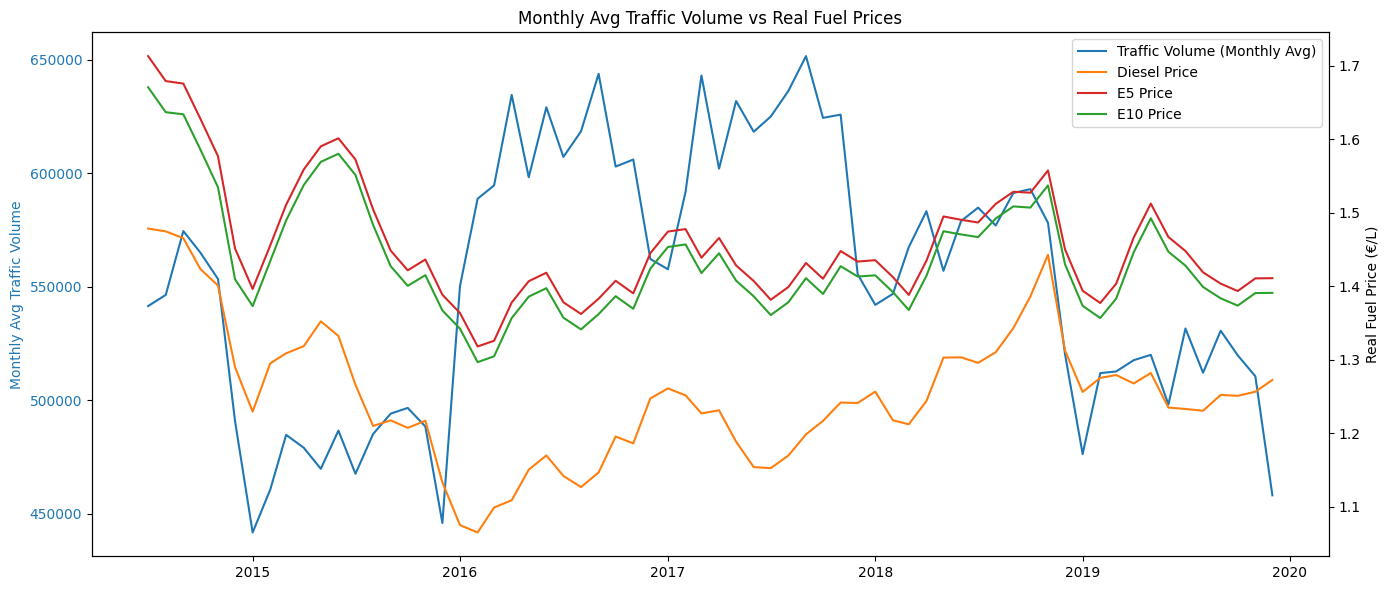

In [48]:
import matplotlib.pyplot as plt

df = pd.read_csv("duesseldorf_daily_panel.csv", parse_dates=["date"])
df["month"] = df["date"].dt.to_period("M").dt.to_timestamp()
df_monthly = df.groupby("month")[["vehicle_total", "diesel_real", "e5_real", "e10_real"]].mean().reset_index()
fig, ax1 = plt.subplots(figsize=(14,6))

ax1.plot(df_monthly["month"], df_monthly["vehicle_total"], color='tab:blue', label="Traffic Volume (Monthly Avg)")
ax1.set_ylabel("Monthly Avg Traffic Volume", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(df_monthly["month"], df_monthly["diesel_real"], color='tab:orange', label="Diesel Price")
ax2.plot(df_monthly["month"], df_monthly["e5_real"], color='tab:red', label="E5 Price")
ax2.plot(df_monthly["month"], df_monthly["e10_real"], color='tab:green', label="E10 Price")
ax2.set_ylabel("Real Fuel Price (€/L)", color='black')
ax2.tick_params(axis='y', labelcolor='black')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

plt.title("Monthly Avg Traffic Volume vs Real Fuel Prices")
plt.tight_layout()
plt.show()

# Modeling

I used daily data, including:

- Total number of vehicles per day (used as a proxy for congestion)
- Prices of three types of fuel: Diesel, E5, and E10 (adjusted for CPI)
- Weather data: temperature and rainfall
- Indicators for whether the day is a public holiday or a weekend

I used a log-linear regression model. The specification is as follows:

$$
\ln(\text{vehicle\_total}_t) = \beta_0 + \sum_{i=1}^3 \left[\beta_i \ln(Fuel^{(i)}_t) + \beta_{i+3} \ln(Fuel^{(i)}_{t-1}) \right] + \beta_7 \text{Temp}_t + \beta_8 \text{Rain}_t + \beta_9 \text{is\_holiday}_t + \beta_{10} \text{is\_weekend}_t + \delta_1 \ln(\text{vehicle\_total}_{t-1}) + \varepsilon_t
$$

Where:
- \( Fuel^{(i)} \) represents the prices of Diesel, E5, and E10 fuel;
- \( \ln(\text{vehicle\_total}_t) \) is the natural log of daily traffic volume;
- The model includes both same-day and one-day lagged fuel prices;
- Weather variables, holiday and weekend dumm


In [50]:
import numpy as np
import statsmodels.api as sm

df = pd.read_csv("duesseldorf_daily_panel.csv", parse_dates=["date"])

df["vehicle_total_log"] = np.log(df["vehicle_total"])
df["vehicle_total_log_lag1"] = df["vehicle_total_log"].shift(1)

for fuel in ["diesel_real", "e5_real", "e10_real"]:
    df[f"{fuel}_log"] = np.log(df[fuel])
    df[f"{fuel}_log_lag1"] = df[f"{fuel}_log"].shift(1)

df_model = df.dropna(subset=[
    "vehicle_total_log", "vehicle_total_log_lag1",
    "diesel_real_log", "diesel_real_log_lag1",
    "e5_real_log", "e5_real_log_lag1",
    "e10_real_log", "e10_real_log_lag1"
])

X_cols = [
    "diesel_real_log", "diesel_real_log_lag1",
    "e5_real_log", "e5_real_log_lag1",
    "e10_real_log", "e10_real_log_lag1",
    "temp", "rain",
    "is_holiday", "is_weekend",
    "vehicle_total_log_lag1"
]

X = sm.add_constant(df_model[X_cols])
y = df_model["vehicle_total_log"]

model = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": 7})
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      vehicle_total_log   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     879.7
Date:                Thu, 26 Jun 2025   Prob (F-statistic):               0.00
Time:                        03:25:00   Log-Likelihood:                 1715.0
No. Observations:                2009   AIC:                            -3406.
Df Residuals:                    1997   BIC:                            -3339.
Df Model:                          11                                         
Covariance Type:                  HAC                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      8

Only the current diesel price comes close to being significant, while the other fuel variables aren’t. That’s probably because the different fuel prices — diesel, E5, and E10 — are highly correlated with each other. In other words, there’s multicollinearity in the model, which makes it hard to distinguish the individual effect of each fuel type. This is supported by the high condition number of 7.74e+04, which indicates severe multicollinearity and numerical instability.

To address this issue, I plan to keep just one representative fuel price variable by averaging E5 and E10 prices. 

$$
\ln(\text{vehicle\_total}_t) = \beta_0 
+ \beta_1 \ln\left(\frac{\text{E5}_t + \text{E10}_t}{2}\right) 
+ \beta_2 \ln\left(\frac{\text{E5}_{t-1} + \text{E10}_{t-1}}{2}\right) 
+ \beta_3 \cdot \text{Temp}_t 
+ \beta_4 \cdot \text{Rain}_t 
+ \beta_5 \cdot \text{is\_holiday}_t 
+ \beta_6 \cdot \text{is\_weekend}_t 
+ \delta \cdot \ln(\text{vehicle\_total}_{t-1}) 
+ \varepsilon_t
$$


In [53]:
df = pd.read_csv("duesseldorf_daily_panel.csv", parse_dates=["date"])

df["vehicle_total_log"] = np.log(df["vehicle_total"])
df["vehicle_total_log_lag1"] = df["vehicle_total_log"].shift(1)

df["fuel_log"] = (np.log(df["e5_real"]) + np.log(df["e10_real"])) / 2
df["fuel_log_lag1"] = df["fuel_log"].shift(1)

df_model = df.dropna(subset=[
    "vehicle_total_log", "vehicle_total_log_lag1",
    "fuel_log", "fuel_log_lag1",
    "temp", "rain", "is_holiday", "is_weekend"
])

X_cols = [
    "fuel_log", "fuel_log_lag1",
    "temp", "rain",
    "is_holiday", "is_weekend",
    "vehicle_total_log_lag1"
]
X = sm.add_constant(df_model[X_cols])
y = df_model["vehicle_total_log"]
model = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": 7})

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      vehicle_total_log   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     1271.
Date:                Thu, 26 Jun 2025   Prob (F-statistic):               0.00
Time:                        03:43:21   Log-Likelihood:                 1704.0
No. Observations:                2009   AIC:                            -3392.
Df Residuals:                    2001   BIC:                            -3347.
Df Model:                           7                                         
Covariance Type:                  HAC                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      8

- **fuel_log**: This is the current average fuel price (E5 + E10). The coefficient is –1.946, and it's highly significant (p = 0.000). Basically, when fuel prices go up by 1%, traffic tends to drop by around **1.95%** — people drive less when gas gets more expensive.
- **fuel_log_lag1**: This is yesterday’s fuel price. The coefficient is +1.667 (p = 0.000), which suggests that people may adjust their travel behavior with a bit of a delay — for example, postponing trips when prices rise.
- **temp**: Temperature has a small but positive effect (+0.0026, p = 0.000). In warmer weather, people are slightly more likely to go out and drive.
- **rain**: Rainfall has a negative impact (–0.0013, p = 0.009), meaning that rainy days tend to keep people off the roads.
- **is_holiday**: On public holidays, traffic drops by about **41%** (coefficient = –0.411, p = 0.000). This makes sense since there’s less commuting.
- **is_weekend**: Weekends also see a big drop in traffic, about **35% lower** than weekdays (coefficient = –0.351, p = 0.000), similar to holidays.
- **vehicle_total_log_lag1**: This is yesterday’s traffic volume. The coefficient is +0.390 (p = 0.000), showing strong persistence — if traffic was high yesterday, it’s likely to be high today too.


# Conclusion
Based on a regression analysis of daily traffic data in the city of Düsseldorf, we find a significant relationship between fuel prices and traffic volume. Specifically, a 1% increase in the current average fuel price is associated with an approximate 1.95% decrease in traffic volume, indicating that higher fuel prices tend to discourage travel and that drivers are clearly price-sensitive. In addition, the previous day’s fuel price has a positive effect on current traffic, suggesting a behavioral lag in response. Even after controlling for weather, holidays, and other factors, the model still explains over 80% of the variation in traffic volume. **Therefore, we conclude that in Düsseldorf, when fuel prices go up, traffic goes down.**

# Challenges and Reflections in the Process
In this analysis, I used highway traffic volume as a proxy for traffic congestion, but was unable to include urban road traffic due to the lack of free and open-access city-level traffic data. This limitation may affect the comprehensiveness of the conclusions.

Regarding control variables, the current model includes factors such as weather and holidays, but does not yet incorporate economic indicators (e.g., unemployment rate). Including such variables in the future could improve the explanatory power of the model.

Data collection was also time-consuming, particularly for fuel prices. The original dataset from Tankerkoenig is nearly 50GB in size, which posed practical challenges. As a result, I limited the analysis period to December 2019 to ensure feasibility and manageability.